# Modeling Template

<ol>
<li></li>
<li>Specify asset universe (eg by ticker symbols)</li>
<li>Read historical data.</li>
<li>(Optionally) append fresh data.</li>
<li>(Optionally) perform common transformations (binning, returns, scaling, etc.)</li>
<li></li>
<li></li>
</ol>

## Example

```Python
# Specify asset universe
assets = ["RDFN", "HD",]

# Read historical data
# Setting `end_date=-1` gets most recent fresh data and caches it.
prices_df = get_price_data(assets, start_date, end_date, ...)
```

# Transition matrix for price moves

Created: 05/10/2024\
Updated: 05/17/2024

In [1]:
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import seaborn as sns
import numpy as np

from configs import FRD_DATA_DIR
from utils import get_prices

pd.set_option('display.max_rows', 100)

## Load price data

In [3]:
asset_type="stock"
adjustment="adj_splitdiv"
period="full"
timeframe="1min"
ticker_symbol="HD"
prices_df = get_prices(asset_type, adjustment, period, timeframe, ticker_symbol)
prices_df

,date,open,high,low,close,volume,day,time,time_id
0,2005-01-03 09:30:00,27.2596,27.2596,27.2279,27.2405,311627.0,2005-01-03,09:30:00,571
1,2005-01-03 09:31:00,27.2405,27.2659,27.2405,27.2659,30753.0,2005-01-03,09:31:00,572
2,2005-01-03 09:32:00,27.2659,27.3293,27.2659,27.2913,41792.0,2005-01-03,09:32:00,573
3,2005-01-03 09:33:00,27.2976,27.3547,27.2469,27.3547,55986.0,2005-01-03,09:33:00,574
4,2005-01-03 09:34:00,27.3610,27.3737,27.3166,27.3166,51097.0,2005-01-03,09:34:00,575
...,...,...,...,...,...,...,...,...,...
1989356,2024-03-08 16:02:00,373.3500,373.3500,373.3500,373.3500,100.0,2024-03-08,16:02:00,963
1989357,2024-03-08 16:06:00,373.3500,373.3500,373.3500,373.3500,5387.0,2024-03-08,16:06:00,967
1989358,2024-03-08 16:20:00,373.3500,373.3500,373.3500,373.3500,184.0,2024-03-08,16:20:00,981
1989359,2024-03-08 18:37:00,373.3300,373.3300,373.3300,373.3300,200.0,2024-03-08,18:37:00,1118


In [216]:
def get_target_matrix(prices_df: pd.DataFrame, target_date:str, thresh:float=0.001) -> pd.DataFrame:
    """
    Get the transition matrix from over {-1, 0, 1} := {decrease, no change, increase}.

    Parameters
    ----------
    prices_df : pd.DataFrame
        The DataFrame containing the price data
    target_date : str
        The target date in the format 'YYYY-MM-DD'
    thresh : float
        The threshold for the target variable

    Returns
    -------
    pd.DataFrame
        The DataFrame containing the target matrix
    """
    target_date = pd.to_datetime(target_date).date()
    
    X = prices_df.copy()
    X = X[["date", "day", "time", "time_id", "open",]]
    X = X[X['day'] == target_date]

    # pad minutes across day
    time_ids = range(1, 1441)
    _X = pd.DataFrame(time_ids, columns=['time_id'])
    _X['datetime'] = pd.date_range(start=pd.Timestamp(target_date), periods=1440, freq='T')
    _X.set_index('time_id', inplace=True)
    X = X.merge(_X, how='right', left_on='time_id', right_index=True)

    # restrict to trading hours
    idx = 1*(X['time_id'] > 570) & (X['time_id'] <= 960+1)
    X["is_trading_hour"] = idx
    X = X[idx]
    
    X.set_index('time_id', inplace=True)
    X.sort_index(inplace=True)

    # Use rolling to find the max opening price in the next 5 minutes
    # Excluding the current minute
    X['next_5_min_max'] = X['open'].rolling(window=5, min_periods=1).max().shift(-5)
    X.to_csv("temp.csv", index=False)

    # Calculate open-to-high change for each bar
    oth_threshold = thresh # tuning param
    X['5min_ch'] = (X['next_5_min_max'] - X['open']) / X['open']
    X['target'] = X['5min_ch'].apply(lambda x: 1 if x > oth_threshold else -1 if x < -oth_threshold else 0)
    return X

# Transition probability matrix

Calculate the $Pr(target_{t} = w | target_{t-1} = w') \text{ for } w\in \{1, 0, -1\}$.

## 1. Running total of counts

## 2. Exponential Smoothing

## 3. Bayesian Updating


Priors
1. Up, down, no change all equally likely
2. No change is most likely (but not 100%), this is essentially an EMH prior
3. Dirichlet distribution


In [217]:
from typing import Union

def get_transition_matrix(df: pd.DataFrame, target: str) -> np.array:
    X = df.copy()
    X[target+"_lag1"] = X[target].shift(1)
    transition_counts = X.groupby([target+'_lag1', target]).size()
    transition_matrix = transition_counts.unstack(fill_value=0)
    state_index = [-1, 0, 1]
    transition_matrix = transition_matrix.reindex(index=state_index, columns=state_index, fill_value=0)
    transition_matrix = np.asarray(transition_matrix.astype(int))
    return transition_matrix

def update_transition_matrix(current: np.array, prior: Union[np.array, str] = "flat", verbose: bool = True) -> np.array:
    """
    Update the prior belief with new data using Bayesian inference.

    Parameters
    ----------
    prior : np.array, optional
        Prior belief (transition matrix). 
        If not provided or equal "flat" then a flat prior is used.
        If "emh" then no change is the dominant transition probability, i.e., $Prob(\\delta x_{t} = 0 | \\delta x_{t-1} = j) = ~1$.
    current : np.array
        Current data (transition matrix).

    Returns
    -------
    np.array
        Posterior belief (transition matrix).
    
    Examples
    --------
    >>> prior = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    >>> current = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> bayesian_update(prior, current)
    array([[0.16666667, 0.33333333, 0.5       ],
           [0.26666667, 0.33333333, 0.4       ],
           [0.29166667, 0.33333333, 0.375     ]])
    """
    n = 390 # number of 1 min bars during trading day
    if prior == "flat":
        prior = np.zeros((3,3))
        prior.fill(n/d)
    elif prior == "emh":
        e = 1/30
        prior = np.asarray([[e, 1-e, e], [e, 1-e, e], [e, 1-e, e]])*n

    prior = prior.astype(int)
    if verbose:
        print("Prior:\n", prior)

    posterior_counts = prior + current
    posterior = posterior_counts / posterior_counts.sum(axis=1, keepdims=True)
    return posterior

In [218]:
class TransitionMatrix:
    def __init__(self, prior="flat"):
        self.n = 390
        if prior == "flat":
            prior = np.zeros((3,3))
            prior.fill(1/9)
        elif prior == "emh":
            e = 1/30
            prior = np.asarray([[e, 1-e, e], [e, 1-e, e], [e, 1-e, e]])
        self.prior = prior
        self.posterior = prior

    def update(self, current):
        """
        Update the prior belief with new data using Bayesian inference.
        """
        # reweight prior
        prior = self.posterior*self.n

        posterior_counts = prior + current

        posterior = posterior_counts / posterior_counts.sum(axis=1, keepdims=True)

        self.posterior = posterior
        self.prior = posterior

        self.n += posterior_counts

In [220]:
import tqdm

days = prices_df['day'].unique()
transition_matrix_results = {}
transition_matrix = TransitionMatrix(prior="flat")
#print(transition_matrix.prior)
#print(transition_matrix.posterior)

#transition_matrix = TransitionMatrix(prior="emh")
#print(transition_matrix.prior)
#print(transition_matrix.posterior)

# loop through days with a progress bar
log = {}
for target_date in tqdm.tqdm(days):
    X = get_target_matrix(prices_df=prices_df, target_date=target_date)
    #print(target_date, X.shape)
    log[target_date] = X.shape
    if len(X) > 3*60:
        current_transition_matrix = get_transition_matrix(df=X, target="target")
        #print(current_transition_matrix)

        transition_matrix.update(current = current_transition_matrix)
        #print(transition_matrix.prior)

        transition_matrix_results[target_date] = transition_matrix.posterior

 18%|█▊        | 890/4828 [19:38<1:10:20,  1.07s/it]

In [210]:
# sns.set(style="white")
# plt.figure(figsize=(18, 6)) 
# for i, (date, matrix) in enumerate(transition_matrix_results.items(), 1):
#     plt.subplot(1, len(transition_matrix_results), i)
#     sns.heatmap(matrix, annot=True, fmt=".2f", cmap='Blues', cbar=False, 
#                 vmin=0, vmax=1, linewidths=.5)
#     plt.title(f'Transition Matrix: {date}')
#     plt.xlabel('Target State')
#     plt.ylabel('Previous State')
#     if i > 1:
#         plt.ylabel('')  # Only show y-label on the first subplot to avoid repetition
# plt.tight_layout()
# plt.show()

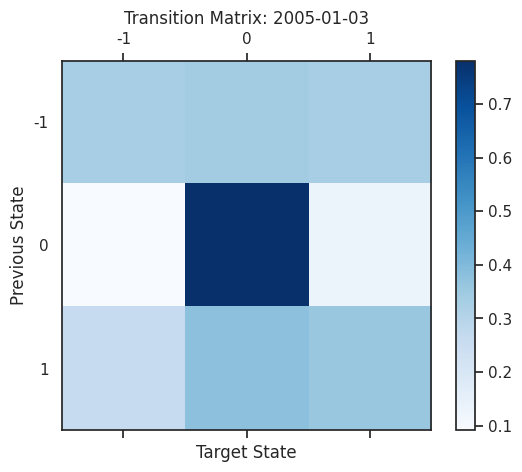

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming transition_matrix_results is defined as shown previously

# Prepare data: Sort the dictionary by date to ensure correct order in animation
dates = sorted(transition_matrix_results.keys())
matrices = [transition_matrix_results[date] for date in dates]

# Setup the figure and axis for the plot
fig, ax = plt.subplots()
cmap = plt.get_cmap('Blues')

# Initialize the heatmap with the first item
matrix = matrices[0]
cax = ax.matshow(matrix, cmap=cmap)

# Add color bar
fig.colorbar(cax)

# Function to update the figure
def update(i):
    ax.cla()  # Clear the axis to update with new data
    ax.matshow(matrices[i], cmap=cmap)
    ax.set_title(f'Transition Matrix: {dates[i]}')
    ax.set_xlabel('Target State')
    ax.set_ylabel('Previous State')
    plt.xticks(ticks=[0, 1, 2], labels=[-1, 0, 1])  # Update x-axis labels
    plt.yticks(ticks=[0, 1, 2], labels=[-1, 0, 1])  # Update y-axis labels

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrices), repeat=True)

# Display the animation
HTML(ani.to_jshtml())


## overnight returns

In [ ]:
X = prices_df.copy()
X.set_index('date', inplace=True)

# Assuming each row in your DataFrame represents a 5min bar within trading hours, and you're interested in 
# the close of the last bar of a day compared to the open of the first bar of the next trading day:

# Resample to get daily close and next day’s open
# The last() method gets you the closing price of the last 5min bar of each day
daily_close = X['close'].resample('D').last()

# The first() method gets you the opening price of the first 5min bar of each day
next_day_open = X['open'].resample('D').first().shift(-1)

# Calculate overnight returns
# Note: This calculation inherently aligns each day's close with the next day's open due to the shift.
overnight_returns = (next_day_open - daily_close) / daily_close

# dropping NaN values that result from the shift operation
overnight_returns.dropna(inplace=True)

# overnight_returns now contains the overnight returns for each trading day
overnight_returns

In [ ]:
# plot overnight returns, color green if positive, red if negative
plt.figure(figsize=(10, 5))
plt.bar(overnight_returns.index, overnight_returns, color=np.where(overnight_returns > 0, 'g', 'r'))
plt.title(f"Overnight returns for {ticker_symbol} {timeframe} {adjustment}")
plt.show()

In [ ]:
# summary stats and eda on overnight returns
print(overnight_returns.describe())
plt.hist(overnight_returns, bins=100)

## short term momentum and reversal

In [ ]:
# Calculate the movement direction for each minute compared to the previous minute
# +1 for up, -1 for down, 0 for no change
df = prices_df.copy()
df['move_dir'] = df['close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['uu'] = (df['move_dir'] == 1) & (df['move_dir'].shift(1) == 1)
df['dd'] = (df['move_dir'] == -1) & (df['move_dir'].shift(1) == -1)
df['ud'] = (df['move_dir'] == -1) & (df['move_dir'].shift(1) == 1)
df['du'] = (df['move_dir'] == 1) & (df['move_dir'].shift(1) == -1)
df[['date', 'close', 'move_dir', 'uu', 'dd', 'ud', 'du']]

In [ ]:
# To calculate frequencies (or counts) for each pattern:
counts = {
    'uu': df['consec_positive'].sum(),
    'dd': df['consec_negative'].sum(),
    'ud': df['ud'].sum(),
    'du': df['du'].sum()
}

# counts now contains the numbers of each pattern occurrence
print(counts)

s = sum(counts.values())
counts = {k: np.round(v/s,4) for k, v in counts.items()}
print(counts)

In [ ]:
# Extracting names (categories) and values (counts)
categories = list(counts.keys())
values = list(counts.values())

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, values)

# Adding titles and labels
plt.title('Frequency of Stock Move Patterns')
plt.xlabel('Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to improve readability

# Display the plot
plt.tight_layout()  # Automatically adjusts subplot params to give specified padding
plt.show()

In [ ]:
# Subset to only data from 2019
prices_df = prices_df[prices_df['date'].dt.year == 2019]

# Extract day from date
prices_df['day'] = prices_df['date'].dt.date
prices_df['time'] = prices_df['date'].dt.time


In [ ]:
# Calculate how often two consecutive price increases occur
prices_df['close_lag_1'] = prices_df['close'].shift(1)
prices_df['close_lag_2'] = prices_df['close'].shift(2)
prices_df['two_up'] = (prices_df['close'] > prices_df['close_lag_1']) & (prices_df['close_lag_1'] > prices_df['close_lag_2'])
prices_df['two_down'] = (prices_df['close'] < prices_df['close_lag_1']) & (prices_df['close_lag_1'] < prices_df['close_lag_2'])
prices_df['up_down'] = (prices_df['close'] > prices_df['close_lag_1']) & (prices_df['close'] < prices_df['close_lag_2'])
prices_df['down_up'] = (prices_df['close'] < prices_df['close_lag_1']) & (prices_df['close'] > prices_df['close_lag_2'])

# get frequencies of up-up, down-down, up-down, and down-up moves in the stock
up_up_freq = prices_df['two_up'].mean()
down_down_freq = prices_df['two_down'].mean()
up_down_freq = prices_df['up_down'].mean()
down_up_freq = prices_df['down_up'].mean()

# plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow([[up_up_freq, up_down_freq], [down_up_freq, down_down_freq]], cmap='YlGn')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['Up', 'Down'])
ax.set_yticklabels([''] + ['Up', 'Down'])
plt.title(f"Price move frequencies for {ticker_symbol}")

# add labels of frequencies (means)
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, round([[up_up_freq, up_down_freq], [down_up_freq, down_down_freq]][i][j], 2),
                       ha="center", va="center", color="black")
plt.show()
